In [1]:
# %%
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.crossover import Crossover
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.core.callback import Callback
from pymoo.optimize import minimize
import random
import copy


data_order = pd.read_excel('Numerical case.xlsx',sheet_name='order information')
data_seru_upper = pd.read_excel('Numerical case.xlsx',sheet_name='seru information upper')
data_seru_lower = pd.read_excel('Numerical case.xlsx',sheet_name='seru information lower')

data_seru = pd.DataFrame(index=data_seru_upper.index, columns=data_seru_upper.columns)
for column in data_seru.columns:
    data_seru[column] = [[round(data_seru_lower.loc[i, column],2), round(data_seru_upper.loc[i, column],2)] for i in data_seru.index]
data_seru[data_seru.columns[0]] = data_seru_lower[data_seru.columns[0]]
num_order = data_order.shape[0]
num_seru = data_seru.shape[0]


class Order:
    def __init__(self, order_id, product_batch, order_weight, product_type, finish_time=0):
        self.order_id = order_id
        self.product_batch = product_batch
        self.order_weight = order_weight
        self.product_type = product_type
        self.finish_time = [999999999,999999999]  # 是灰数
    def show_info(self):
        print('-------------------------')
        print("订单编号：", self.order_id)
        print("产品批量：", self.product_batch)
        print("订单权重：", self.order_weight)
        print("产品类型：", self.product_type)
        print("完工时间:", self.finish_time)
        
        
class Seru:
    def __init__(self, seru_id, seru_order=[], seru_work_time=0, seru_capacity=None, seru_type=[]):
        self.seru_id = seru_id
        self.seru_order = []
        self.seru_work_time = [0,0]  # 是灰数
        self.seru_capacity = seru_capacity
        self.seru_type = []
        self.flag = False  # 该seru是否包含不可加工订单
    def cal_type(self):
        """通过加工能力列表生成可加工类型列表"""
        self.seru_type = [i+1 for i in range(len(self.seru_capacity)) if not(np.isnan(self.seru_capacity[i][0]))]
    def process(self, order):
        """将订单分配到指定seru"""
        self.cal_type()
        self.seru_order.append(order.order_id)
        # 如果seru可以加工该类型产品
        if order.product_type in self.seru_type:
            self.seru_work_time[0] += self.seru_capacity[order.product_type-1][0]*order.product_batch  # 是灰数
            self.seru_work_time[1] += self.seru_capacity[order.product_type-1][1]*order.product_batch  # 是灰数
            order.finish_time = [self.seru_work_time[0],self.seru_work_time[1]]
        else:
            self.flag = True
    def show_info(self):
        print('----------------')
        print('seru_id:', self.seru_id)
        print('seru_order:', self.seru_order)
        print('seru_work_time:', self.seru_work_time)
        print('seru_capacity:', self.seru_capacity)
        print('seru_type:', self.seru_type)
        print('process_unable:', self.flag)


def evaluation(order_list):
    """根据传入的染色体和订单信息，计算出该染色体对应方案的加权完工时间"""
    fitness = [0,0]  # 是灰数
    for i in range(len(order_list)):
        fitness[0] += order_list[i].finish_time[0] * order_list[i].order_weight
        fitness[1] += order_list[i].finish_time[1] * order_list[i].order_weight
    fitness = [round(i,2) for i in fitness]
    fitness =  sum(fitness)/2
    return fitness


def gen_chrom(num_order, num_seru, data_seru):
    sequence = np.random.permutation(list(range(1,num_order+1)))
    process_able_matrix = np.zeros([num_seru,data_seru.shape[1]-1])
    for i in range(num_seru):
        for j in range(data_seru.shape[1]-1):
            if np.isnan(data_seru.iloc[i][j+1][0]):
                pass
            else:
                process_able_matrix[i,j] = j+1
    process_able_list = [[int(value) for value in row if value != 0] for row in process_able_matrix]
    product_types = set()
    for machine in process_able_list:
        product_types.update(machine)
    product_to_machine = {product: [] for product in product_types}
    for machine_index, machine in enumerate(process_able_list):
        for product in machine:
            product_to_machine[product].append(machine_index+1)
    result = [product_to_machine[product] for product in sorted(product_to_machine)]
    sequence = np.random.permutation(list(range(1,num_order+1)))
    sequence_type = [data_order.iloc[i-1]['product type'] for i in sequence]
    assign = [np.random.choice(result[sequence_type[i]-1]) for i in range(num_order)]
    x = np.concatenate([sequence, assign],axis=0)
    return x


def decode(X):
    sequence = X[:num_order]
    assign = X[num_order:]
    order_list = [Order(
        order_id=data_order.iloc[i-1]['order ID'],
        product_batch=data_order.iloc[i-1]['product quantity'],
        order_weight=data_order.iloc[i-1]['order weight'],
        product_type=data_order.iloc[i-1]['product type'],
        ) for i in sequence]
    seru_list = [Seru(
        seru_id=data_seru.iloc[i]['seru ID\process time'],
        seru_capacity=list(data_seru.iloc[i][1:])
        ) for i in range(num_seru)]
    for i in range(num_order):
        seru_list[assign[i]-1].process(order_list[i])
    return order_list,seru_list


class MyProblem(ElementwiseProblem):
    def __init__(self, num_order, num_seru, **kwargs):
        chrom = [0]*(num_order*2)
        super().__init__(vars=chrom, n_obj=1, xl=0, xu=num_order, n_ieq_constr=0)
        self.num_order = num_order
        self.num_seru = num_seru
    def _evaluate(self, x, out, *args, **kwargs):
        order_list,seru_list = decode(x)
        fitness = evaluation(order_list)
        out["F"] = fitness
        
        
class MySampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples,2*num_order), None, dtype=object)
        for i in range(n_samples):
                X[i,:] = gen_chrom(num_order, num_seru, data_seru)
        return X


def order_crossover(p1,p2,point_1,point_2):
    p1_seg = p1[point_1:point_2]
    p2_seg = p2[point_1:point_2]
    off1_seg,off2_seg = [],[]  # 子代的片段
    off1_seg = [i for i in p2 if i in p1_seg]  # 子代1的片段
    off2_seg = [i for i in p1 if i in p2_seg]  # 子代2的片段
    off1,off2 = copy.deepcopy(p1),copy.deepcopy(p2)  # 子代个
    for i in range(point_1,point_2):
        off1[i] = off1_seg[i-point_1]
        off2[i] = off2_seg[i-point_1]
    return off1,off2


class MyCrossover(Crossover):
    def __init__(self):
        super().__init__(2,2)
    def _do(self,problem,X,**kwargs):
        _,n_matings,n_var = X.shape
        Y = np.full_like(X, 0, dtype=int)
        for k in range(n_matings):
            a,b = X[0,k,:],X[1,k,:]
            a_sequence = a[:num_order]
            b_sequence = b[:num_order]
            a_assign = a[num_order:]
            b_assign = b[num_order:]
            point_1 = random.randint(0, problem.num_order-1)
            point_2 = random.randint(0, problem.num_order-1)
            point_min = min(point_1, point_2)
            point_max = max(point_1, point_2)
            off_a,off_b = copy.deepcopy(order_crossover(a_sequence,b_sequence,point_min,point_max))
            point_3 = random.randint(0, problem.num_order-1)
            seg11 = a_assign[point_3:]
            seg12 = a_assign[:point_3]
            seg21 = b_assign[point_3:]
            seg22 = b_assign[:point_3]
            off_c = np.concatenate((seg11,seg22),axis=0)
            off_d = np.concatenate((seg21,seg12),axis=0)
            chrom_a = np.concatenate([off_a,off_c],axis=0)
            chrom_b = np.concatenate([off_b,off_d],axis=0)
            Y[0,k,:] = chrom_a
            Y[1,k,:] = chrom_b
        return Y


class Mymutation(Mutation):
    def __init__(self):
        super().__init__()
    def _do(self,problem,X,**kwargs):
        for i in range(len(X)):
            r = np.random.random()
            if r < 0.1:
                chrom = list(X[i])
                sequence = chrom[:num_order]
                point_1 = random.randint(0, problem.num_order-1)
                point_2 = random.randint(0, problem.num_order-1)
                sequence[point_1],sequence[point_2] = sequence[point_2],sequence[point_1]
                assign = chrom[num_order:]
                point_3 = random.randint(0, problem.num_order-1)
                assign[point_3] = random.randint(1, problem.num_seru)
                X[i] = np.concatenate([sequence,assign],axis=0)
        return X


class MyNeighborhoodSearch:
    
    def __init__(self) -> None:
        pass
    
    # def search(self, problem, x):
    #     # 执行邻域搜索操作，将该订单随机分配到其它seru中
    #     candidate_list = []
    #     out = {}
    #     problem._evaluate(x,out)
    #     for j in range(num_order,2*num_order-1):
    #         for i in range(1,num_seru+1):
    #             base = copy.deepcopy(x)
    #             base[j] = i
    #             candidate_list.append(base)
        
    #     for i in candidate_list:
    #         out_new = {}
    #         problem._evaluate(i,out_new)
    #         if out_new['F'] < out['F']:
    #             print('gengxin1',out_new['F'])
    #             return i

    #     return x

    def search(self, problem, x):
        # 执行邻域搜索操作，将该订单随机分配到其它seru中
        candidate_list = []
        out = {}
        problem._evaluate(x, out)
        current_best_value = out['F']
        
        # 使用字典缓存已经计算过的解及其评估结果
        evaluated_solutions = {}

        # 遍历订单和seru
        for j in range(num_order, 2 * num_order - 1):
            for i in range(1, num_seru + 1):
                # 创建一个新的解，避免深拷贝
                new_x = copy.deepcopy(x)
                new_x[j] = i
                
                # 将解转为元组形式以便可以作为字典的键
                new_x_tuple = tuple(new_x)
                
                # 检查这个解是否已经计算过
                if new_x_tuple in evaluated_solutions:
                    out_new = evaluated_solutions[new_x_tuple]
                else:
                    out_new = {}
                    problem._evaluate(new_x, out_new)
                    # 将新的解的评估结果存入缓存
                    evaluated_solutions[new_x_tuple] = out_new

                # 如果新解更优，则直接返回
                if out_new['F'] < current_best_value:
                    print('-------------------------------------------------')
                    print('   邻域搜索找到更优解','  |  ',round(out_new['F'],2))
                    print('-------------------------------------------------')
                    return new_x
                
        # 如果没有找到更优解，则返回原解
        return x

class MyCallback(Callback):
    def __init__(self, search) -> None:
        super().__init__()
        self.search = search
        self.best_individual = None
        self.history = []

    
    def notify(self, algorithm):
        pop = algorithm.pop

        # 第一代，随机选择一个个体作为初始最优个体
        if self.best_individual is None:
            self.best_individual = pop[0].X

        # 找到当前代的最优个体
        best_index = np.argmin(pop.get("F"))  # 这里以第一个目标函数为例
        best_individual = pop[best_index].X

        self.best_individual = best_individual
        problem = algorithm.problem

        # 执行邻域搜索并得到新的解
        x_new = self.search.search(problem, best_individual)
        
        # 更新最优个体的解
        pop[best_index].X = x_new

        # 重新评估更新后的个体适应度
        out_new = {}
        problem._evaluate(x_new, out_new)  # 使用解 x_new 重新评估适应度
        pop[best_index].F[0] = np.array(out_new['F'].item())

        self.history.append(algorithm.pop.get('F').min())


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      300 |  5.318225E+03 |  4.550840E+03
-------------------------------------------------
   邻域搜索找到更优解   |   4542.05
-------------------------------------------------
     2 |      600 |  5.314521E+03 |  4.542050E+03
-------------------------------------------------
   邻域搜索找到更优解   |   4535.74
-------------------------------------------------
     3 |      900 |  5.306848E+03 |  4.535745E+03
-------------------------------------------------
   邻域搜索找到更优解   |   4530.16
-------------------------------------------------
     4 |     1200 |  5.301676E+03 |  4.530155E+03
-------------------------------------------------
   邻域搜索找到更优解   |   4526.82
-------------------------------------------------
     5 |     1500 |  5.291664E+03 |  4.526820E+03
-------------------------------------------------
   邻域搜索找到更优解   |   4480.91
-------------------------------------------------
     6 |     1800 |  5.291511E+03 |  4.480910E+03
---------------

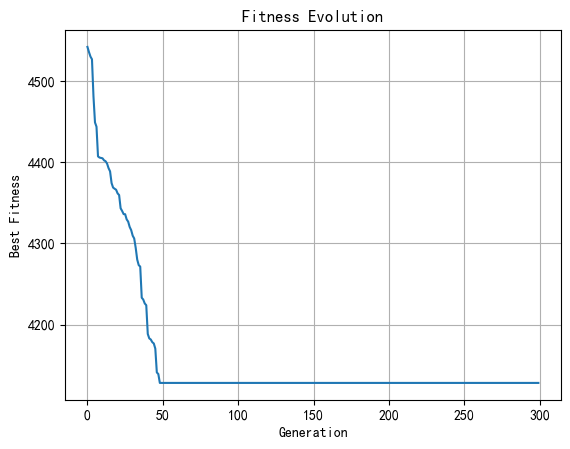

In [2]:
m = MyProblem(num_order=num_order, num_seru=num_seru)

algorithm = GA(
    sampling=MySampling(),
    crossover=MyCrossover(),
    mutation = Mymutation(),
    pop_size=300,
    eliminate_duplicates=True)

search = MyNeighborhoodSearch()
# history = MyCallback(search)
res = minimize(
        m,
        algorithm,
        ('n_gen',300),
        verbose=True,
        callback=MyCallback(search),
        save_history=False)
best_X = res.X
best_F = res.F
order_list1,seru_list1=decode(best_X)
ans = evaluation(order_list1)
for seru in seru_list1:
    seru.show_info()
print(best_X[:num_order])
print(best_X[num_order:])
print(best_F)
best_X

# %%
# 绘制适应度变化趋势
history = res.algorithm.callback.history
plt.plot(history)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Fitness Evolution')
plt.grid(True)
plt.show()

In [3]:
history_save = [round(i,2) for i in history]
history_df = pd.DataFrame({'平均目标值':history_save})
history_df.to_csv('有邻域搜索的适应度变化.csv')